In [1]:
# Import necesary modules
import numpy as np
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt

# 1. Mathematical model

We are given the following Hamiltonian:

$$ \hat{H}(t) = \begin{bmatrix} 0 & \beta \\ \beta & 0 \end{bmatrix} + E_0 \sin(\omega t)\begin{bmatrix} -d & 0 \\ 0 & d \end{bmatrix} $$

And we have to integrate the following equation of motion:

$$ |\psi(t+\Delta t)\rangle = \hat{U}(t)|\psi(t)\rangle \ , $$

using two different aproximations for the propagator. The first case is a first order approximation:

$$ \hat{U}(t) = \hat{I} - \frac{i}{\hbar}\hat{H}\Delta t \ , $$

while the second case is called the Crank-Nicholson propagator:

$$ \hat{U}(t) = \frac{\hat{I} + (i/2\hbar)\hat{H}\Delta t}{\hat{I} - (i/2\hbar)\hat{H}\Delta t}$$

To make the simulations easier we'll use $\hbar\equiv1$.

We have to prepare the system in the fundamental state, this is the eigenstate $|\psi\rangle$ that satisfies the following:

$$\hat{H}(t=0)|\psi\rangle = \min\{\beta,-\beta\}|\psi\rangle$$

# 2. Finding the fundamental state

We know that the Hamiltonian at time $t=0$ is given by:

$$ \hat{H}(t=0) = \begin{bmatrix} 0 & \beta \\ \beta & 0 \end{bmatrix}$$

This is diagonalized by the following eigenstates:

$$ |\beta\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 \\ 1 \end{bmatrix} \ \ \text{and} \ \ 
   |-\beta\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 \\ -1 \end{bmatrix} \ \ ,$$
   
with eigenvalues $\beta$ and $-\beta$ respectively.

In [2]:
# Let's define a function that can generate the fundamental 
# state of the system for any value of beta
def get_fundamental(beta):
    c = 1/np.sqrt(2)
    if beta <= 0:
        return c*np.array([[1],[1]])
    elif beta > 0:
        return c*np.array([[1],[-1]])
    

# We should also define a function that generates
# the excited state
def get_excited(beta):
    c = 1/np.sqrt(2)
    if beta <= 0:
        return c*np.array([[1],[-1]])
    elif beta > 0:
        return c*np.array([[1],[1]])

# 3. Designing a pipeline for the simulations

In [3]:
# STEP 1
# Let's define the Hamiltonian class
class Hamiltonian():
    def __init__(self, beta, E_0, omega, d):
        '''
        Params:
            beta : float
                Parameter for the time independent term of H.
            E_0 : float
                Maximum energy for the time dependent term of H.
            omega : float
                Angular frequency for the time dependent term of H.
            d : float
                Parameter for the diagonal matrix of the time dependent term in H.

        Output:
            Initializes the Hamiltonian object.
        '''
        self.beta = beta
        self.E_0 = E_0
        self.omega = omega
        self.d = d
        
    def apply(self, t):
        '''
        Params:
            t : float
                Value for the time parameter
        Output:
            Returns a numpy array H, built using the following definition:
                /0    beta\                           /-d  0\
            H = \beta 0   /  + E_0 * sin(omega * t) * \ 0  d/
        '''
        return np.array([[0,self.beta],[self.beta,0]]) + self.E_0*np.sin(self.omega*t)*np.array([[-self.d,0],
                                                                                                 [0,self.d]])
    
    
# STEP 2
# Now let's build a propagator class
class Propagator():
    def __init__(self, delta_t, H):
        '''
        Params:
            delta_t : float
                Time interval to be applied in between each step of the integration.
            H : Hamiltonian object
                Hamiltonian of the sistem, expresed as a matrix in a given base.
        Output:
            Initializes the Propagator object.
        '''
        self.delta_t = delta_t
        self.H = H
        
    # Let's define the first order approximation
    def first_order(self,t,psi_t):
        '''
        Params:
            t : float or int
                Value of the time parameter.
            psi_t : numpy array
                Vector representation of the state of the system at time t.
        Output:
            Applies a first order approximation of the propagator to the psi_t
            state and returns the state of the system in vector representation
            at time t+self.delta_t
        '''
        U_first_ord = np.array([[1.0,0],[0,1.0]]) - 1j*self.H.apply(t)*self.delta_t
        return U_first_ord @ psi_t
    
    
    def Crank_Nicholson(self,t,psi_t):
        '''
        Params:
            t : float or int
                Value of the time parameter.
            psi_t : numpy array
                Vector representation of the state of the system at time t.
        Output:
            Applies a Crank-Nicholson approximation of the propagator to the psi_t
            state and returns the state of the system in vector representation
            at time t+self.delta_t
        '''
        U_cn_top = np.array([[1.0,0],[0,1.0]]) + (1j/2)*self.H.apply(t)*self.delta_t
        U_cn_bott = np.linalg.inv(np.array([[1.0,0],[0,1.0]]) - (1j/2)*self.H.apply(t)*self.delta_t)
        U_cn = U_cn_top @ U_cn_bott
        return U_cn @ psi_t
    
    
# STEP 3
# We'll define a pipeline that makes simulations easier to perform and track

# First an auxiliary function
def inner_prod(psi, theta):
    '''
    Params:
        psi : numpy array
            State to be used as the bra of the inner product
        theta : numpy array
            State to be used as the ket of the inner product
    
    Output:
        Returns the bra-ket inner product <psi|theta>.
    '''
    psi_bra = np.conjugate(np.transpose(psi))
    
    return (psi_bra @ theta)[0][0]


class Pipeline():
    def __init__(self,delta_t,beta, E_0, omega, d):
        '''
        Params:
            delta_t : float
                Time interval to be applied in between each step of the integration.
            beta : float
                Parameter for the time independent term of H.
            E_0 : float
                Maximum energy for the time dependent term of H.
            omega : float
                Angular frequency for the time dependent term of H.
            d : float
                Parameter for the diagonal matrix of the time dependent term in H.
                
        Output:
            Initializes the Pipeline object.
        '''
        self.delta_t = delta_t
        self.beta = beta
        self.E_0 = E_0
        self.omega = omega
        self.d = d
        
        # Start time parameter
        self.t = 0
        
        # We get the fundamental state of the system
        self.state = get_fundamental(beta)
        # Now we build the Hamiltonian 
        self.H = Hamiltonian(beta, E_0, omega, d)
        # And the propagator
        self.U = Propagator(delta_t, self.H)
        
        # Initialize history of the system 
        self.history = [get_fundamental(beta)]
        
        # Initialize history of the expected value for H
        self.H_history = [np.real(inner_prod(self.state, 
                                self.H.apply(t=0)@self.state))]
        
    def get_expected_H(self):
        self.H_history.append(np.real(inner_prod(self.state,
                                self.H.apply(self.t)@self.state)))
        
    def step_first_order(self):
        '''
        Output:
            Updates the state of the system using the first order
            approximation of the Propagator, saves new state to the
            system history and updates the value of t.
        '''
        old_state = self.state
        new_state = self.U.first_order(self.t,old_state)
        self.state = new_state.copy()
        # Add new state to system history
        self.history.append(new_state)
        # Add new expected energy value
        self.get_expected_H()
        # Update time
        self.t += self.delta_t
        
    
    def step_crank_nicholson(self):
        '''
        Output:
            Updates the state of the system using the Crank-Nicholson
            approximation of the Propagator, saves new state to the
            system history and updates the value of t.
        '''
        old_state = self.state
        new_state = self.U.Crank_Nicholson(self.t,old_state)
        self.state = new_state.copy()
        # Add new state to system history
        self.history.append(new_state)
        # Add new expected energy value
        self.get_expected_H()
        # Update time
        self.t += self.delta_t
        
    

# STEP 4
# Define auxiliary functios that can help us visualize the results
def get_probs(pipeline,mode='fundamental'):
    '''
    Params:
        pipeline : Pipeline
            Pipeline containing the simulation results in history attribute.
        mode : str
            Projection mode. 'fundamental' gets the fundamental state 
            probability, while 'excited' gets the excited state probability.
    
    Output:
        Returns a numpy array of the requested probabilities, for every step of 
        the pipeline history.
    '''
    # Let's get the proyection state
    if mode == 'fundamental':
        state = get_fundamental(pipeline.beta)
    elif mode == 'excited':
        state = get_excited(pipeline.beta)
    else:
        print('Error: mode must be either "fundamental" or "excited".')
        return
    
    # Get probabilities
    probs_list = []
    for psi in pipeline.history:
        prob = np.absolute(inner_prod(state,psi))
        probs_list.append(prob)
        
    # Turn into numpy array and get squares
    probs_list = np.power(np.array(probs_list),2)
    return probs_list

    
    
def compare_histories(pipelines, mode='all', labels=None,
                      filepath=None):
    '''
    Params:
        pipelines : list
            List of Pipeline objects, containing histories to be
            compared.
        mode : str
            Plotting mode. 'fundamental' plots the fundamental state probability,
            'excited' plots the excited state probability, 'energy' plots the 
            energy of the system, and 'all' plots all the previous options.
        labels : list or None
            List of str labels, with same amount of elements as pipelines. If
            None, then predetermined labels are used.
        filepath : str or None
            File path to save the generated plots, if None then the plots aren't saved.
        
    Output:
        Plots the requested information, comparing the provided pipelines.
    '''
    if labels == None:
        labels = []
        i = 1
        for p in pipelines:
            message = 'Pipeline ' + str(i)
            labels.append(message)
            i+=1
            
    if mode == 'fundamental' or mode == 'all':
        fig1 = plt.figure(figsize=(13,8))
        i = 0
        for p in pipelines:
            # Get probs for fundamental state
            probs = get_probs(p,mode='fundamental')
            plt.plot((p.delta_t)*np.linspace(0,len(probs),num=len(probs)), 
                     probs, label=labels[i], linewidth=2)
            i += 1
        plt.xlabel('t',fontsize=20)
        plt.ylabel('$P_{fundamental}$', fontsize=20)
        plt.xticks(size=18)
        plt.yticks(size=18)
        plt.xlim(left=0)
        plt.ylim(bottom=0)
        plt.legend(fontsize=20)
        
        if filepath != None:
            plt.savefig('fundamental_'+filepath)
        
    if mode == 'excited' or mode == 'all':
        fig2 = plt.figure(figsize=(13,8))
        i = 0
        for p in pipelines:
            # Get probs for fundamental state
            probs = get_probs(p,mode='excited')
            plt.plot((p.delta_t)*np.linspace(0,len(probs),num=len(probs)), 
                     probs, label=labels[i], linewidth=2)
            i += 1
        plt.xlabel('t',fontsize=20)
        plt.ylabel('$P_{excited}$', fontsize=20)
        plt.xticks(size=18)
        plt.yticks(size=18)
        plt.xlim(left=0)
        plt.ylim(bottom=0)
        plt.legend(fontsize=20)
        
        if filepath != None:
            plt.savefig('excited_'+filepath)
        
    if mode == 'energy' or mode == 'all':
        fig3 = plt.figure(figsize=(13,8))
        i = 0
        for p in pipelines:
            # Get probs for fundamental state
            energies = p.H_history
            plt.plot((p.delta_t)*np.linspace(0,len(energies),num=len(energies)), 
                     energies, label=labels[i], linewidth=2)
            i += 1
        plt.xlabel('t',fontsize=20)
        plt.ylabel(r'$\langle H\rangle$', fontsize=20)
        plt.xticks(size=18)
        plt.yticks(size=18)
        plt.xlim(left=0)
        #plt.ylim(bottom=0)
        plt.legend(fontsize=20)
        
        if filepath != None:
            plt.savefig('H_'+filepath)
        
    plt.show()

# 4. Comparing the different propagator approximations

## 4.1 Different values of $\Delta t$ for a fixed time duration $t_{max}$

In [10]:
# Let's prepare some delta_t values, we'll use some fixed constants
# for the rest of the parameters
BETA, E_0, OMEGA, D = 0.5, 3, np.pi, 2
delta_t_list = [0.01,0.001,0.0001]

# First order simulations
FO_sims = [Pipeline(delta_t=delta_t, 
                    beta=BETA,E_0=E_0, 
                    omega=OMEGA,d=D) for delta_t in delta_t_list]

# Crank-Nicholson simulations
CN_sims = [Pipeline(delta_t=delta_t, 
                    beta=BETA,E_0=E_0, 
                    omega=OMEGA,d=D) for delta_t in delta_t_list]

# Let's run the simulations, adjusting the steps so that the 
# time duration is the same for every sim
t_max = 5
for i in range(len(delta_t_list)):
    steps = int(t_max/delta_t_list[i])
    fo_sim = FO_sims[i]
    cn_sim = CN_sims[i]
    for s in range(steps):
        fo_sim.step_first_order()
        cn_sim.step_crank_nicholson()

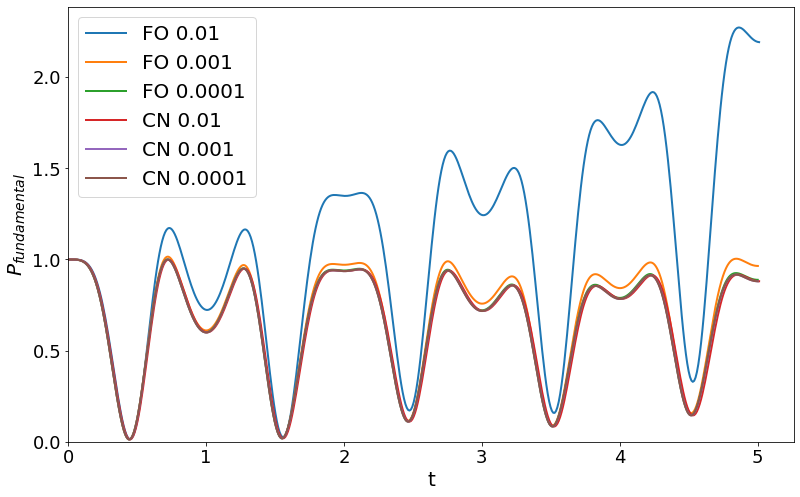

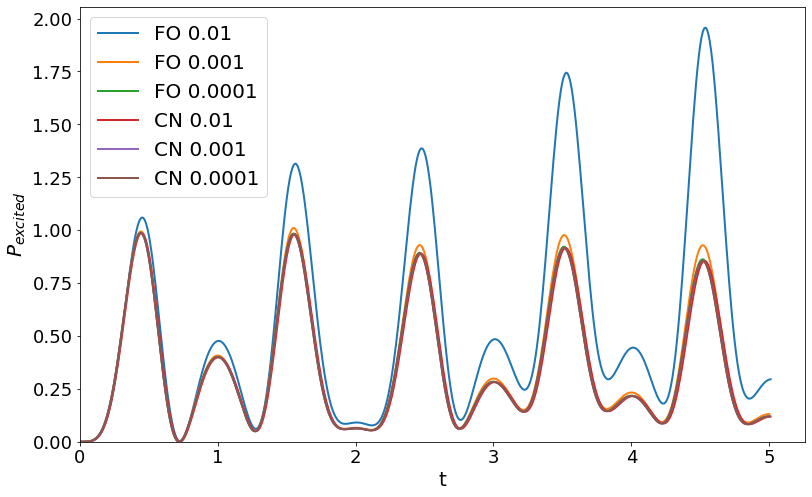

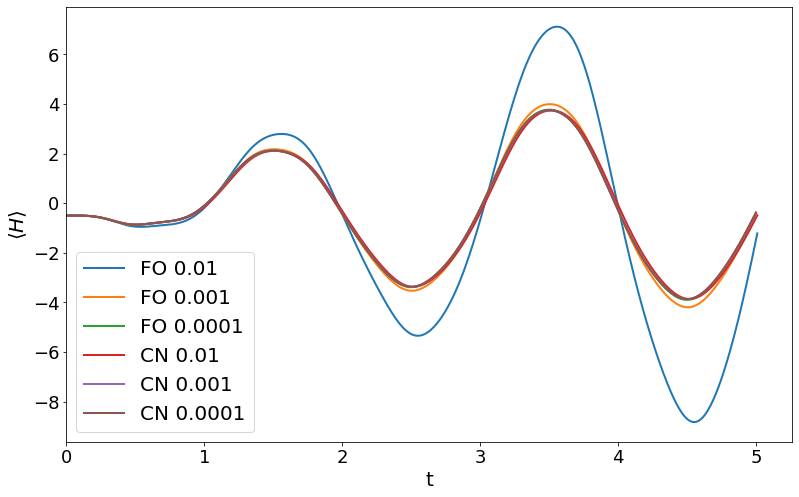

In [11]:
# Build labels and plot
FO_labels = ['FO ' + str(p.delta_t) for p in FO_sims]
CN_labels = ['CN ' + str(p.delta_t) for p in CN_sims]
all_labels = FO_labels.copy()
all_labels.extend(CN_labels)

all_sims = FO_sims.copy()
all_sims.extend(CN_sims.copy())

compare_histories(all_sims, labels=all_labels, filepath='delta_t_FO_vs_CN.png')

At a first glance, it seems that the Crank-Nicholson approximation can get the same results as the first order approximation, using a $\Delta t$ that is bigger by 2 orders of magnitude.

## 4.2 Fixed value of $\Delta t$ for different values of duration $t_{max}$

In [574]:
# Let's prepare some delta_t values, we'll use some fixed constants
# for the rest of the parameters
DELTA_T, BETA, E_0, OMEGA, D = 0.001, 0.5, 3, np.pi, 2
t_list = [10,20,100]

# First order simulations
FO_sims = [Pipeline(delta_t=DELTA_T, 
                    beta=BETA,E_0=E_0, 
                    omega=OMEGA,d=D) for i in range(len(t_list))]

# Crank-Nicholson simulations
CN_sims = [Pipeline(delta_t=DELTA_T, 
                    beta=BETA,E_0=E_0, 
                    omega=OMEGA,d=D) for i in range(len(t_list))]

# Let's run the simulations, adjusting the steps so that the 
# time duration is the same for every sim
for i in range(len(t_list)):
    steps = int(t_list[i]/DELTA_T)
    fo_sim = FO_sims[i]
    cn_sim = CN_sims[i]
    for s in range(steps):
        fo_sim.step_first_order()
        cn_sim.step_crank_nicholson()

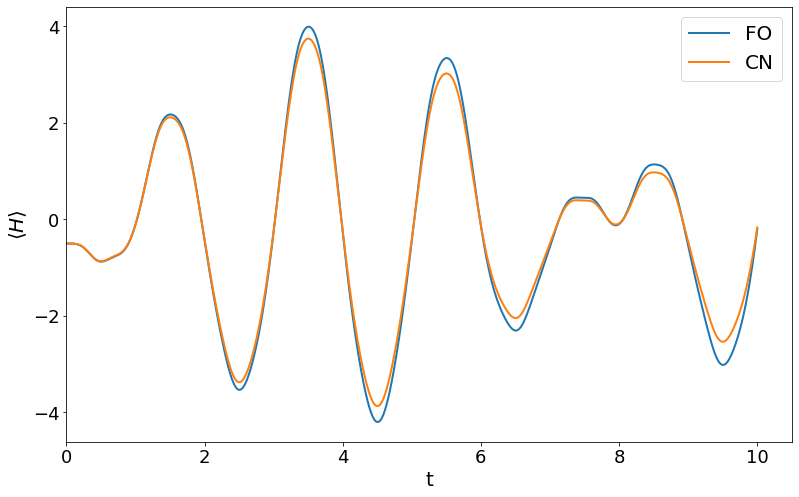

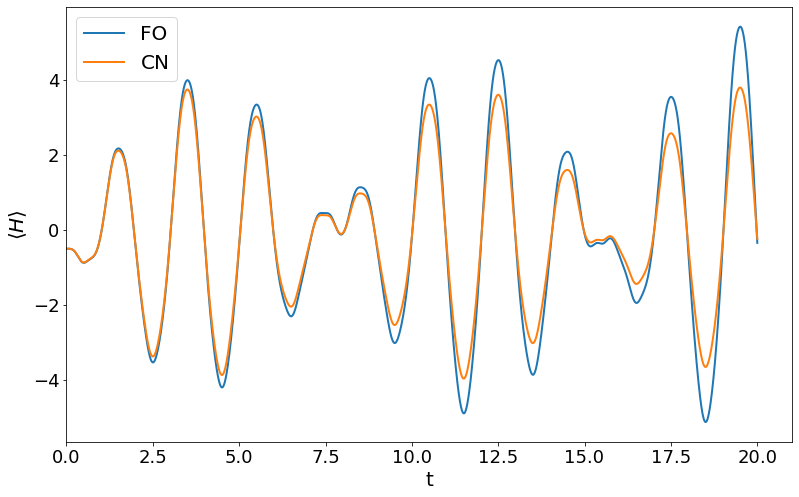

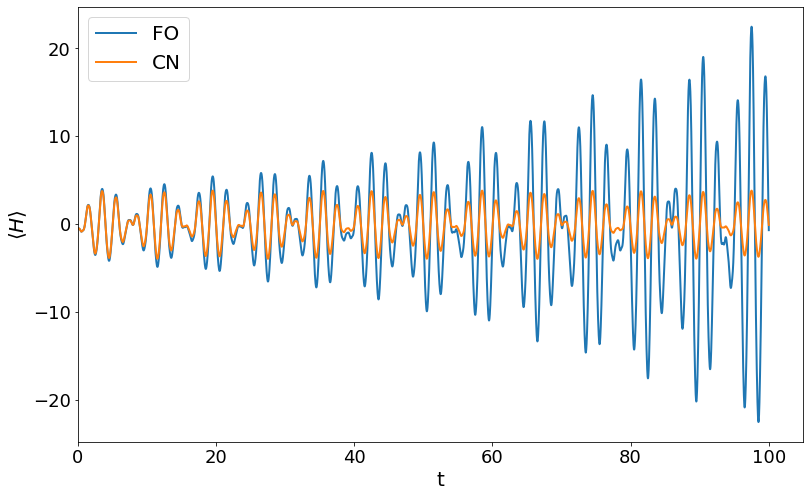

In [576]:
# Build labels and plot
all_labels = ['FO','CN']
for i in range(len(t_list)):
    t = str(t_list[i])
    compare_histories([FO_sims[i],CN_sims[i]], mode='energy', labels=all_labels, 
                      filepath='max_t_'+t+'_FO_vs_CN')

This confirms that the Crank-Nicholson approximation is better than the first order method.

# 5. Comparing different values for the system parameters

## 5.1 Resonance vs. No-resonance cases

We know that the system has a resonance frequency of:

$$\omega = \frac{2\beta}{\hbar} $$

In [560]:
# Build different values for omega and set other parameters
DELTA_T, BETA, E_0, D = 0.00002, 0.5, 1, 0.5
omegas = [5*BETA, 2*BETA, BETA, 0.5*BETA]

omega_sims = [Pipeline(delta_t = DELTA_T, beta=BETA, 
                      E_0=E_0, omega=omega, d=D) for omega in omegas]

# Run the simulations
t_max = 15
steps = int(t_max/DELTA_T)
for i in range(len(omegas)):
    sim = omega_sims[i]
    print('Performing simulation %d of %d' % (i+1,len(omegas)))
    for s in range(steps):
        sim.step_crank_nicholson()

Performing simulation 1 of 4
Performing simulation 2 of 4
Performing simulation 3 of 4
Performing simulation 4 of 4


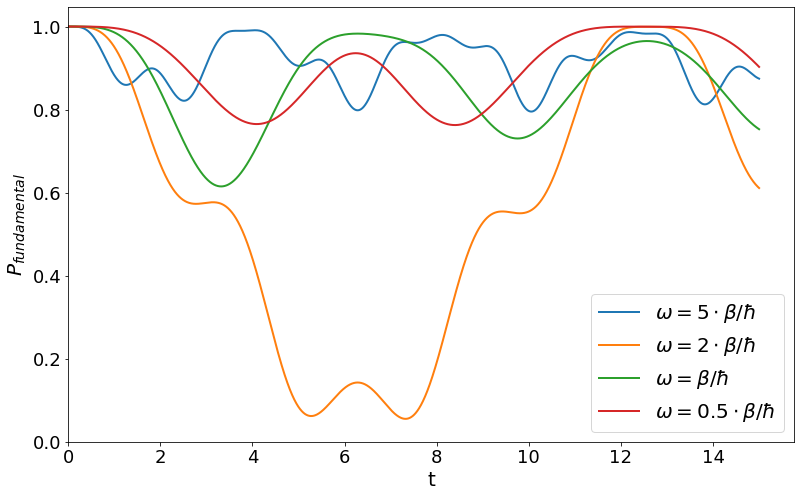

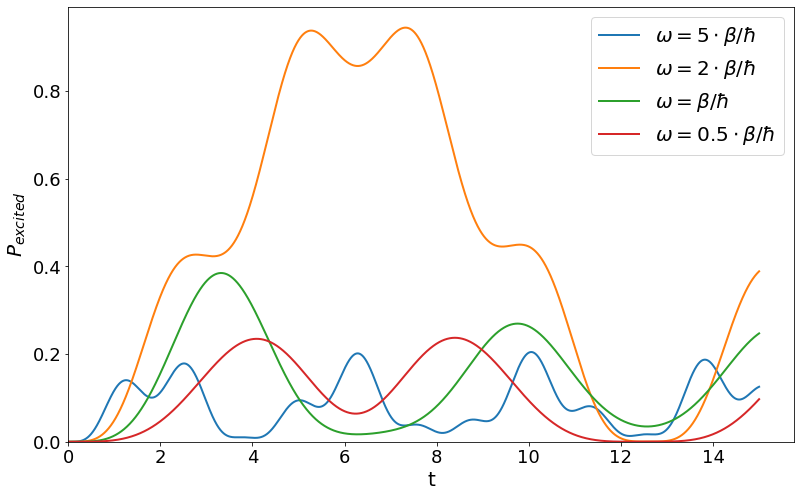

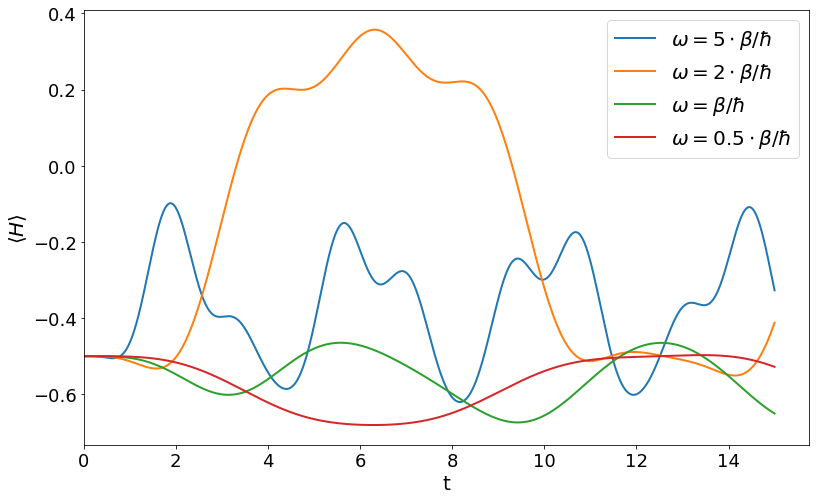

In [579]:
# Build plots
labels = [r'$\omega=5\cdot\beta/\hbar$',r'$\omega=2\cdot\beta/\hbar$',
          r'$\omega=\beta/\hbar$',r'$\omega=0.5\cdot\beta/\hbar$']
compare_histories(omega_sims, mode='all', labels=labels,
                 filepath='omega_CN.png')

## 5.2 Different values of $E_0 d/\beta$

In [591]:
# Build different values for E_0 and set other parameters
DELTA_T, BETA, OMEGA, D = 0.00005, 0.5, 2, 0.5
E_0_list = [10, 1, 0.5, 0.1]

E_0_sims = [Pipeline(delta_t = DELTA_T, beta=BETA, 
                      E_0=E_0, omega=OMEGA, d=D) for E_0 in E_0_list]

# Run the simulations
t_max = 15
steps = int(t_max/DELTA_T)
for i in range(len(E_0_list)):
    sim = E_0_sims[i]
    print('Performing simulation %d of %d' % (i+1,len(E_0_list)))
    for s in range(steps):
        sim.step_crank_nicholson()

Performing simulation 1 of 4
Performing simulation 2 of 4
Performing simulation 3 of 4
Performing simulation 4 of 4


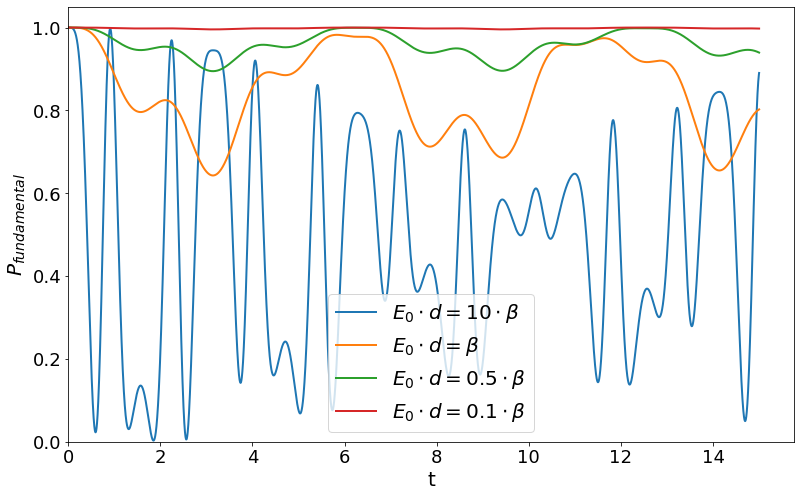

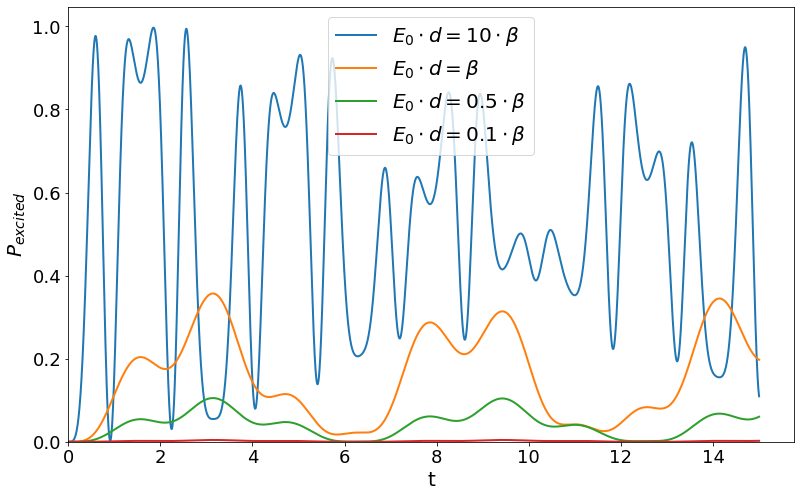

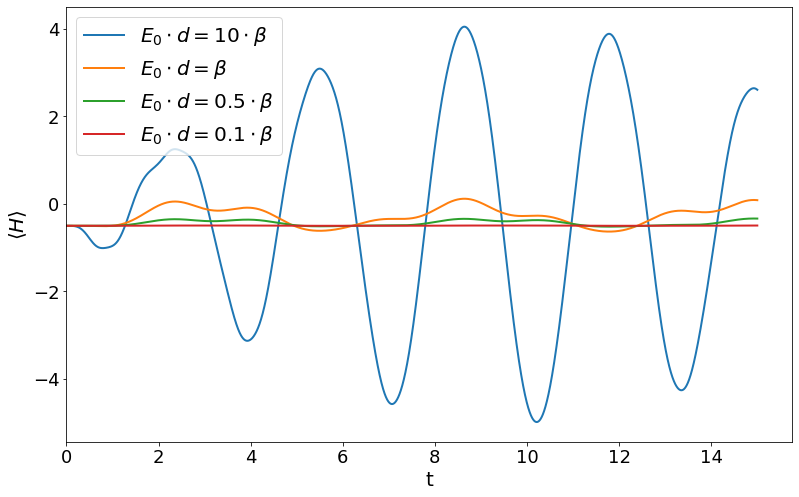

In [592]:
# Build plots
labels = [r'$E_0\cdot d=10\cdot\beta$',r'$E_0\cdot d=\beta$',
          r'$E_0\cdot d=0.5\cdot\beta$',r'$E_0\cdot d=0.1\cdot\beta$']
compare_histories(E_0_sims, mode='all', labels=labels,
                 filepath='E_0_CN.png')

# 6. Adding a Gaussian pulse to the system

## 6.1 Building the new pipeline

We now want to simulate the system given by the following Hamiltonian:

$$ \hat{H}(t) = \begin{bmatrix} 0 & \beta \\ \beta & 0 \end{bmatrix} + \frac{E_0}{\sqrt{2\pi}\sigma} \sin(\omega t)\exp\left(\frac{-(t-t_0)^2}{2\sigma^2}\right)\begin{bmatrix} -d & 0 \\ 0 & d \end{bmatrix} $$

In [593]:
# Define Gaussian pulse Hamiltonian child class
class PulseHamiltonian(Hamiltonian):
    def __init__(self,beta, E_0, omega, d, t_0, sigma):
        super().__init__(beta, E_0, omega, d)
        self.t_0 = t_0
        self.sigma = sigma
        
        
    def apply(self, t):
        '''
        Params:
            t : float
                Value for the time parameter
        Output:
            Returns a numpy array H, built using the definition stated in section 6
            for the Gaussian pulse Hamiltonian.
        '''
        H_matrix = np.array([[0,self.beta],[self.beta,0]]) +\
            (self.E_0/(np.sqrt(2*np.pi)*self.sigma)
                )*np.sin(self.omega*t)*np.exp(-(t-self.t_0)**2/(2*(self.sigma**2)))*np.array([[-self.d,0],
                                                                                        [0,self.d]])
        return H_matrix
        
        

# Define child class from Pipeline
class PulsePipeline(Pipeline):
    def __init__(self,delta_t,beta, E_0, omega, d, t_0, sigma):
        '''
        Params:
            delta_t : float
                Time interval to be applied in between each step of the integration.
            beta : float
                Parameter for the time independent term of H.
            E_0 : float
                Maximum energy for the time dependent term of H.
            omega : float
                Angular frequency for the time dependent term of H.
            d : float
                Parameter for the diagonal matrix of the time dependent term in H.
                
        Output:
            Initializes the Pipeline object.
        '''
        self.delta_t = delta_t
        self.beta = beta
        self.E_0 = E_0
        self.omega = omega
        self.d = d
        self.t_0 = t_0
        self.sigma = sigma
        
        # Start time parameter
        self.t = 0
        
        # We get the fundamental state of the system
        self.state = get_fundamental(beta)
        # Now we build the Hamiltonian 
        self.H = PulseHamiltonian(beta, E_0, omega, d, t_0, sigma)
        # And the propagator
        self.U = Propagator(delta_t, self.H)
        
        # Initialize history of the system 
        self.history = [get_fundamental(beta)]
        
        # Initialize history of the expected value for H
        self.H_history = [np.real(inner_prod(self.state, 
                                self.H.apply(t=0)@self.state))]


In [628]:
P1 = PulsePipeline(0.00005,0.5,5,2,0.5,2,0.2)

In [629]:
for i in range(100000):
    P1.step_crank_nicholson()

## 6.2 Caracterization of the pulse with different intensity values

In this case, we fix the values of every parameter except $E_0$, which can be interpreted as the intensity of the pulse. The other parameters are $\Delta t = 0.00005$, $\beta = 0.5$, $\omega=2$, $d=0.5$, $t_0=2$ and $\sigma=0.2$.

In [638]:
# Build different values for E_0 and set other parameters
DELTA_T, BETA, OMEGA, D, T_0, SIGMA = 0.00005, 0.5, 2, 0.5, 2, 0.2
E_0_list = [5, 4.5, 4, 3, 2]

pulse_sims = [PulsePipeline(delta_t = DELTA_T, beta=BETA, 
                E_0=E_0, omega=OMEGA, d=D, t_0=T_0, sigma=SIGMA) for E_0 in E_0_list]

# Run the simulations
t_max = 5
steps = int(t_max/DELTA_T)
for i in range(len(E_0_list)):
    sim = pulse_sims[i]
    print('Performing simulation %d of %d' % (i+1,len(E_0_list)))
    for s in range(steps):
        sim.step_crank_nicholson()

Performing simulation 1 of 5
Performing simulation 2 of 5
Performing simulation 3 of 5
Performing simulation 4 of 5
Performing simulation 5 of 5


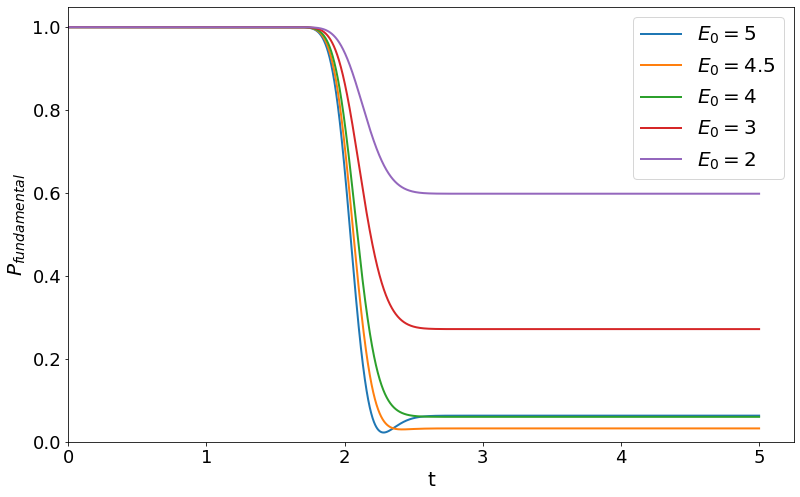

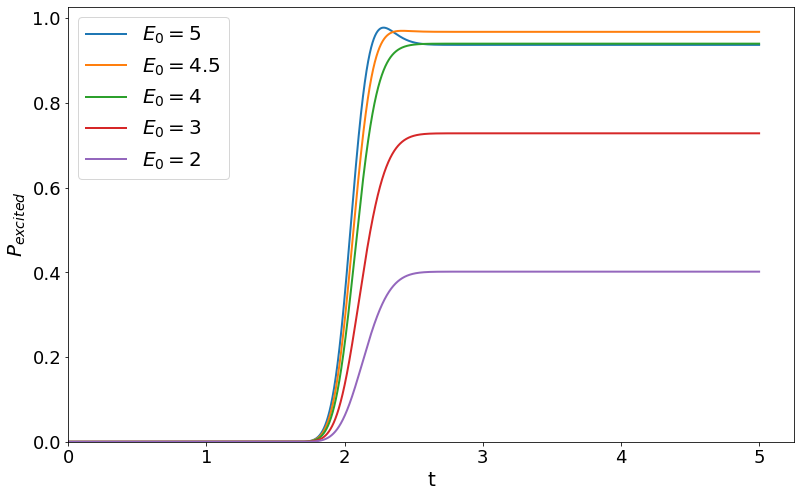

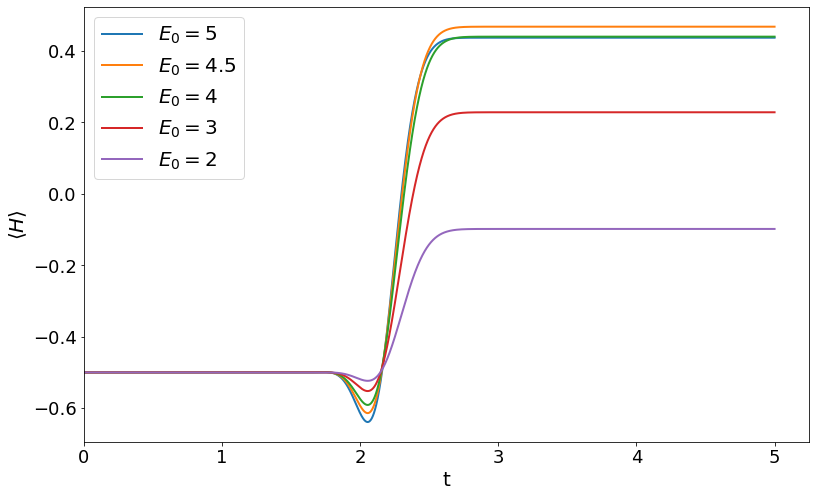

In [639]:
# Build plots
labels = [r'$E_0 = 5$',r'$E_0 = 4.5$',r'$E_0 = 4$',r'$E_0 = 3$',r'$E_0 = 2$']
compare_histories(pulse_sims, mode='all', labels=labels,
                 filepath='Pulse_E_0_CN.png')

## 6.3 Testing different values for $\sigma$

We fix the other parameters: $\Delta t = 0.00005$, $\beta = 0.5$, $E_0=4.3$, $\omega=2$, $d=0.5$ and $t_0=2$.

In [658]:
# Build different values for sigma and set other parameters
DELTA_T, BETA, E_0, OMEGA, D, T_0 = 0.00005, 0.5, 4.3, 2, 0.5, 2
sigma_list = [0.4, 0.2, 0.1, 0.01]

sigma_sims = [PulsePipeline(delta_t = DELTA_T, beta=BETA, 
                E_0=E_0, omega=OMEGA, d=D, t_0=T_0, sigma=sigma) for sigma in sigma_list]

# Run the simulations
t_max = 5
steps = int(t_max/DELTA_T)
for i in range(len(sigma_list)):
    sim = sigma_sims[i]
    print('Performing simulation %d of %d' % (i+1,len(sigma_list)))
    for s in range(steps):
        sim.step_crank_nicholson()

Performing simulation 1 of 4
Performing simulation 2 of 4
Performing simulation 3 of 4
Performing simulation 4 of 4


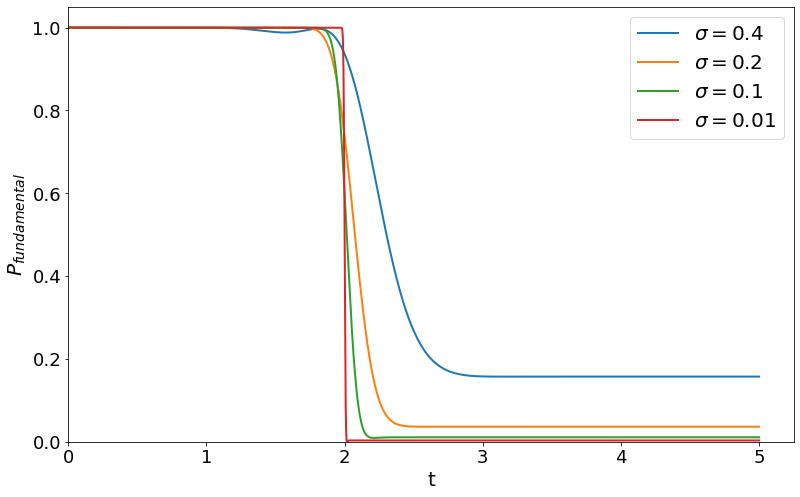

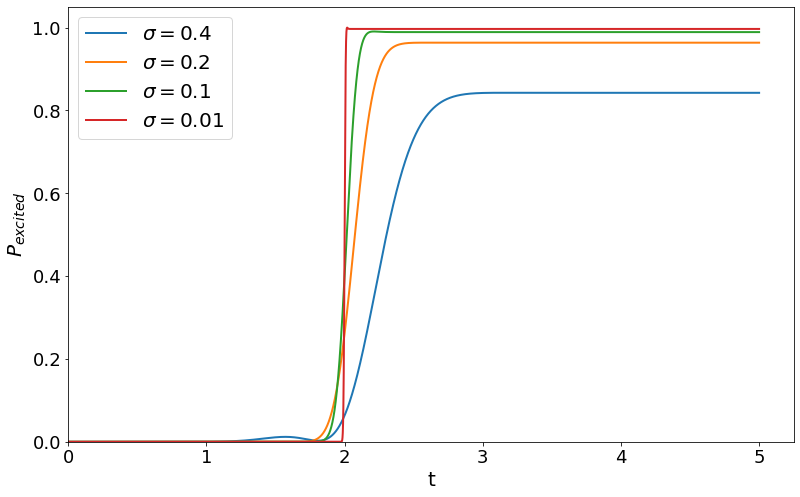

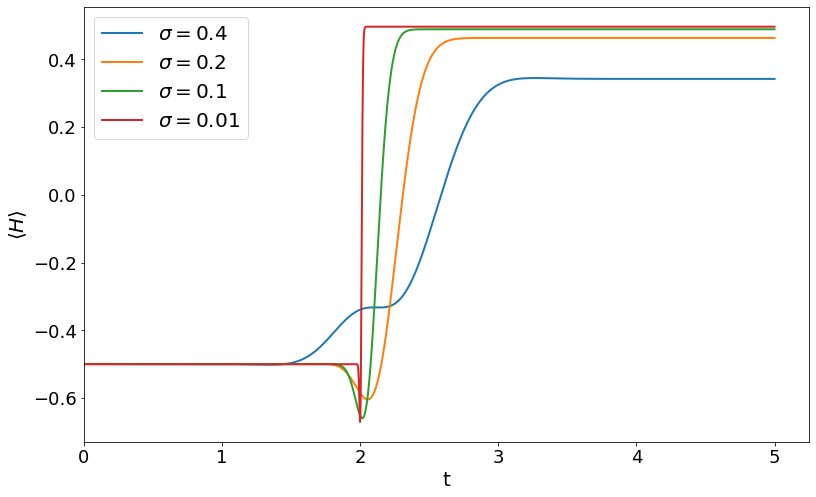

In [659]:
# Build plots
labels = [r'$\sigma = 0.4$',r'$\sigma = 0.2$',r'$\sigma = 0.1$',r'$\sigma = 0.01$']
compare_histories(sigma_sims, mode='all', labels=labels,
                 filepath='Pulse_sigma_CN.png')

## 6.4 Double pulse

In [689]:
# Let's build a single pipeline
P1 = PulsePipeline(delta_t=0.00005,beta=0.5,E_0=4.3,omega=2,d=0.5,t_0=2,sigma=0.005)

# We simulate up to t=3
t_max_1 = 3
steps = int(t_max_1/P1.delta_t)
for s in range(steps):
    P1.step_crank_nicholson()
    
# Now we change the t_0 of the pulse to 5
# and simulate up to t=6
P1.t_0 = 5
P1.H.t_0 = 5
t_max_2 = 3
steps = int(t_max_2/P1.delta_t)
for s in range(steps):
    P1.step_crank_nicholson()

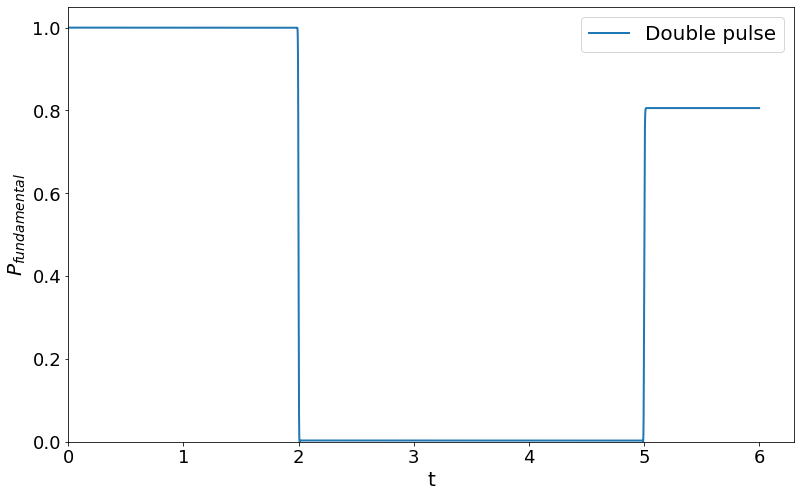

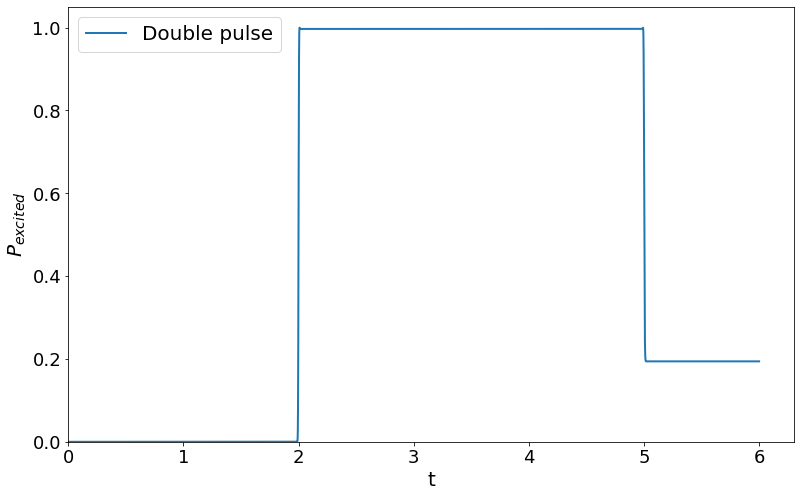

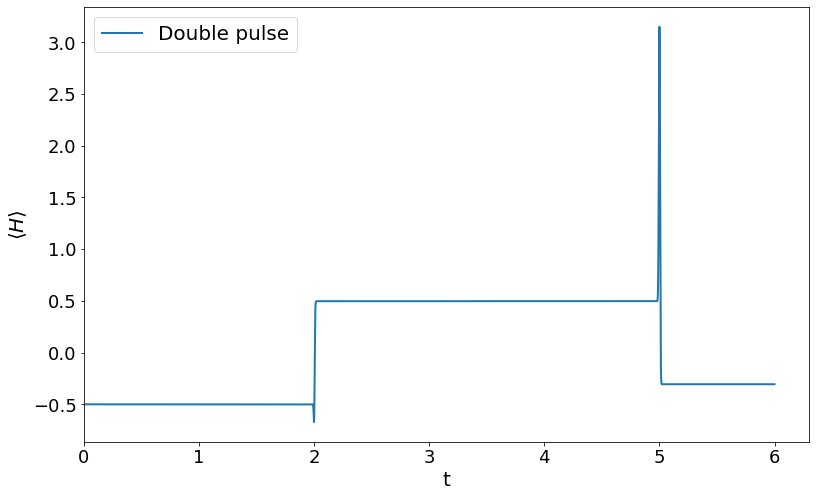

In [690]:
# Plot the results
compare_histories([P1],labels=['Double pulse'],filepath='double_pulse.png')

## 6.5 Double pulse with inverted field $E_0$

In [686]:
# Let's build a single pipeline
P1 = PulsePipeline(delta_t=0.00005,beta=0.5,E_0=4.3,omega=2,d=0.5,t_0=2,sigma=0.005)

# We simulate up to t=3
t_max_1 = 3
steps = int(t_max_1/P1.delta_t)
for s in range(steps):
    P1.step_crank_nicholson()
    
# Now we change the t_0 of the pulse to 5
# and simulate up to t=6. We also change
# the sign of E_0
P1.t_0 = 5
P1.E_0 = -P1.E_0
P1.H.t_0 = 5
P1.H.E_0 = P1.E_0
t_max_2 = 3
steps = int(t_max_2/P1.delta_t)
for s in range(steps):
    P1.step_crank_nicholson()

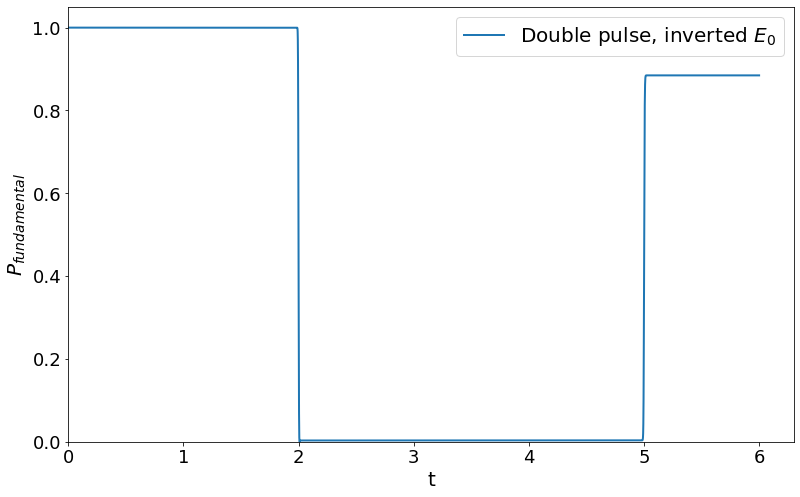

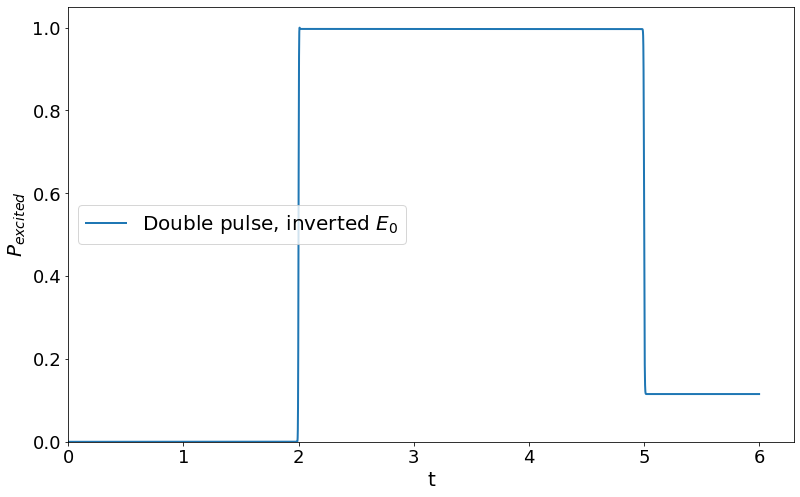

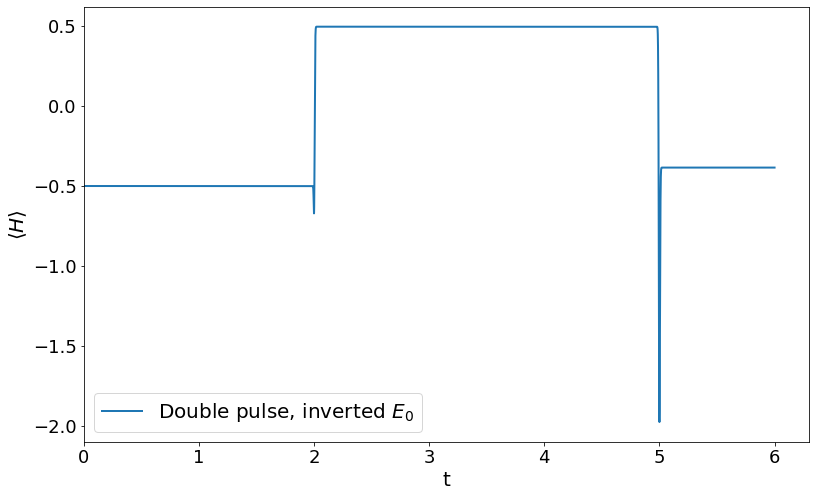

In [688]:
# Plot the results
compare_histories([P1],labels=['Double pulse, inverted $E_0$'], filepath='double_pulse_invert_E_0.png')

Changing the sign of the field $E_0$ seems to get the system closer to the fundamental state, but doesn't fully reach it either.